In [1]:
import logging
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)

from hydro_forecasting.experiment_utils.seed_manager import SeedManager  # noqa: E402

seed_manager = SeedManager(42)
seed_manager.set_global_seeds()

2025-07-09 14:29:30,278 - lightning_fabric.utilities.seed - INFO - Seed set to 42


In [2]:
import hydro_forecasting.experiment_utils.checkpoint_manager as checkpoint_manager
from hydro_forecasting.data.caravanify_parquet import CaravanifyParquet, CaravanifyParquetConfig
from hydro_forecasting.data.in_memory_datamodule import HydroInMemoryDataModule
from hydro_forecasting.model_evaluation.evaluators import TSForecastEvaluator
from hydro_forecasting.model_evaluation.hp_from_yaml import hp_from_yaml
from hydro_forecasting.model_evaluation.visualization import (
    plot_basin_performance_scatter,
    plot_horizon_performance_bars,
    plot_horizon_performance_boxplots,
    plot_model_cdf_grid,
    plot_rolling_forecast,
    plot_median_performance_across_models,
    plot_ensemble_rolling_forecast,
    remaining_skill_captured_vs_horizon
)
from hydro_forecasting.model_evaluation.performance_evaluation import (
    generate_performance_summary,
    print_performance_summary
)
from hydro_forecasting.models.dummy import LitRepeatLastValues, RepeatLastValuesConfig
from hydro_forecasting.models.ealstm import EALSTMConfig, LitEALSTM
from hydro_forecasting.models.tft import LitTFT, TFTConfig
from hydro_forecasting.models.tide import LitTiDE, TiDEConfig
from hydro_forecasting.models.tsmixer import LitTSMixer, TSMixerConfig
from hydro_forecasting.preprocessing import PipelineBuilder

---

In [3]:
forcing_features = [
    "snow_depth_water_equivalent_mean",
    "surface_net_solar_radiation_mean",
    "surface_net_thermal_radiation_mean",
    "potential_evaporation_sum_ERA5_LAND",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "temperature_2m_mean",
    "temperature_2m_min",
    "temperature_2m_max",
    "total_precipitation_sum",
]

static_features = [
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

target = "streamflow"

In [4]:
REGIONS = ["CA"]

COUNTRY = "tajikistan"  # "tajikistan" or "kyrgyzstan"
ON_COUNTRY = "kyrgyzstan" if COUNTRY == "tajikistan" else "tajikistan"

MODEL_TYPES = [
    "tft",
    "ealstm",
    "tide",
    "tsmixer",
]

EXPERIMENT_TYPES = {
    # "pretrained": f"similar_catchments/similar-catchments_{COUNTRY.lower()}",
    # "finetuned": f"finetune/finetune_from_similar_catchments_{COUNTRY.lower()}",
    "low_hii": f"finetune/finetune_from_low_medium_hii_{COUNTRY.lower()}",
    "benchmark": f"benchmark/benchmark_in_memory_{COUNTRY.lower()}",
    # "regional": f"finetune/regional_transfer_to_{COUNTRY.lower()}_from_{ON_COUNTRY.lower()}",
    "similar": f"finetune/finetune_similar_{COUNTRY.lower()}"
}

BASE_PATH = Path("/Users/cooper/Desktop/hydro-forecasting/experiments")

# IMAGE_SAVE_FOLDER = Path(f"/Users/cooper/Desktop/hydro-forecasting/images/global_transfer_learning/{COUNTRY.lower()}")
IMAGE_SAVE_FOLDER = Path(f"/Users/cooper/Desktop/hydro-forecasting/images/global_transfer_learning/{COUNTRY.lower()}/in_RAM")

In [5]:
# ealstm_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/unified/{COUNTRY.lower()}/ealstm.yaml"
# tft_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/unified/{COUNTRY.lower()}/tft.yaml"
# tide_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/unified/{COUNTRY.lower()}/tide.yaml"
# tsmixer_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/unified/{COUNTRY.lower()}/tsmixer.yaml"

ealstm_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/ealstm.yaml"
tft_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tft.yaml"
tide_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tide.yaml"
tsmixer_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tsmixer.yaml"


tft_hp = hp_from_yaml("tft", tft_yaml)
tide_hp = hp_from_yaml("tide", tide_yaml)
ealstm_hp = hp_from_yaml("ealstm", ealstm_yaml)
tsmixer_hp = hp_from_yaml("tsmixer", tsmixer_yaml)

The following parameters were not found in the YAML file and will use defaults:
  - hidden_continuous_size (model-specific)
  - quantiles (model-specific)
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)
The following parameters were not found in the YAML file and will use defaults:
  - future_forcing_projection_size (model-specific)
  - past_feature_projection_size (model-specific)
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)
The following parameters were not found in the YAML file and will use defaults:
  - bias (model-specific)
  - bidirectional (model-specific)
  - bidirectional_fusion (model-specific)
  - future_hidden_size (model-specific)
  - future_layers (model-specific)
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)
The following parameters were not found in the YAML file and will use defaults:
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)


In [6]:
TFT_config = TFTConfig(**tft_hp)
EALSTM_config = EALSTMConfig(**ealstm_hp)
TiDE_config = TiDEConfig(**tide_hp)
TSMixer_config = TSMixerConfig(**tsmixer_hp)

dummy_config = RepeatLastValuesConfig(
    input_len=ealstm_hp["input_len"],
    input_size=ealstm_hp["input_size"],
    output_len=ealstm_hp["output_len"],
)

---

In [7]:
def load_basin_ids(country: str) -> list[str]:
    """
    Function to load basins for a given country in Central Asia
    """
    # Make country lowercase and make the first letter uppercase
    country = country.lower()
    country = country.capitalize()

    if country != "Tajikistan" and country != "Kyrgyzstan":
        print("Country not supported")
        return []

    configs = CaravanifyParquetConfig(
        attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
        timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
        gauge_id_prefix="CA",
        use_hydroatlas_attributes=True,
        use_caravan_attributes=True,
        use_other_attributes=True,
    )

    caravan = CaravanifyParquet(configs)
    ca_basins = caravan.get_all_gauge_ids()
    caravan.load_stations(ca_basins)
    static_data = caravan.get_static_attributes()

    return list(static_data[static_data["country"] == country]["gauge_id"].unique())


country_ids = load_basin_ids(COUNTRY)

In [8]:
print(f"Found {len(country_ids)} total CA basins in {COUNTRY}")

Found 16 total CA basins in tajikistan


---

In [9]:
builder = PipelineBuilder()

feature_section = (
    builder.features().transforms(["standard_scale", "normalize"]).strategy("per_group", group_by="gauge_id").columns(forcing_features)
)

target_section = (
    builder.target()
    .transforms(["standard_scale", "normalize"])
    .strategy("per_group", group_by="gauge_id")
    .columns([target])
)

static_section = builder.static_features().transforms(["standard_scale"]).strategy("unified").columns(static_features)

preprocessing_config = builder.build()

In [10]:
region_time_series_base_dirs = {
    region: f"/Users/cooper/Desktop/CaravanifyParquet/{region}/post_processed/timeseries/csv/{region}"
    for region in REGIONS
}

region_static_attributes_base_dirs = {
    region: f"/Users/cooper/Desktop/CaravanifyParquet/{region}/post_processed/attributes/{region}" for region in REGIONS
}

In [11]:
data_modules = {
    name: HydroInMemoryDataModule(
        region_time_series_base_dirs=region_time_series_base_dirs,
        region_static_attributes_base_dirs=region_static_attributes_base_dirs,
        path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/data_cache/first_eval",
        group_identifier="gauge_id",
        batch_size=2048,
        input_length=hp["input_len"],
        output_length=hp["output_len"],
        forcing_features=forcing_features,
        static_features=static_features,
        target=target,
        preprocessing_configs=preprocessing_config,
        num_workers=4,
        min_train_years=5,
        train_prop=0.5,
        val_prop=0.25,
        test_prop=0.25,
        max_imputation_gap_size=5,
        list_of_gauge_ids_to_process=country_ids,
        is_autoregressive=True,
        chunk_size=100,
        validation_chunk_size=100,
        random_seed=42,
    )
    for name, hp in [
        ("tft_data_module", tft_hp),
        ("tide_data_module", tide_hp),
        ("tsmixer_data_module", tsmixer_hp),
        ("ealstm_data_module", ealstm_hp),
    ]
}

tft_data_module = data_modules["tft_data_module"]
tide_data_module = data_modules["tide_data_module"]
tsmixer_data_module = data_modules["tsmixer_data_module"]
ealstm_data_module = data_modules["ealstm_data_module"]

2025-07-09 14:29:30,857 - lightning_fabric.utilities.seed - INFO - Seed set to 42
2025-07-09 14:29:30,863 - lightning_fabric.utilities.seed - INFO - Seed set to 42
2025-07-09 14:29:30,866 - lightning_fabric.utilities.seed - INFO - Seed set to 42
2025-07-09 14:29:30,871 - lightning_fabric.utilities.seed - INFO - Seed set to 42


In [12]:
from hydro_forecasting.exceptions import ConfigurationError, FileOperationError


def get_checkpoint_for_model(model_type: str, checkpoint_folder: Path, select_overall_best: bool = True) -> Path | None:
    """
    Function to get the best checkpoint for a given model type.

    Args:
        model_type: Type of model to load checkpoint for
        checkpoint_folder: Base directory containing checkpoints
        select_overall_best: Whether to select the overall best model

    Returns:
        Path to checkpoint file, or None if not found or error occurred
    """
    try:
        return checkpoint_manager.get_checkpoint_path_to_load(
            base_checkpoint_load_dir=checkpoint_folder, model_type=model_type, select_overall_best=select_overall_best
        )
    except (ConfigurationError, FileOperationError) as e:
        print(f"Failed to load checkpoint for {model_type}: {e}")
        return None


def load_all_checkpoints(
    country: str, model_types: list[str] | None = None, experiment_types: dict[str, str] | None = None
) -> dict[str, dict[str, Path | None]]:
    """
    Load checkpoints for all model types across all experiment types.

    Args:
        country: Country code for the experiments
        model_types: List of model types to load (defaults to common ones)
        experiment_types: Dict mapping experiment names to directory patterns

    Returns:
        Dict of {experiment_type: {model_type: checkpoint_path}}
    """
    # Default model types
    if model_types is None:
        model_types = ["tft", "tide", "ealstm", "tsmixer"]

    base_path = BASE_PATH
    checkpoints = {}

    for exp_name, exp_path in experiment_types.items():
        checkpoints[exp_name] = {}
        checkpoint_dir = base_path / exp_path / "checkpoints"

        for model_type in model_types:
            checkpoint_path = get_checkpoint_for_model(
                model_type=model_type, checkpoint_folder=checkpoint_dir, select_overall_best=True
            )
            checkpoints[exp_name][model_type] = checkpoint_path

    return checkpoints


def print_checkpoints(checkpoints: dict[str, dict[str, Path | None]]) -> None:
    """Print checkpoints in a read∆∆∆∆able format."""
    for exp_name, models in checkpoints.items():
        valid_paths = [str(path) for path in models.values() if path is not None]
        failed_models = [model for model, path in models.items() if path is None]


        print(f"{exp_name.capitalize()} checkpoints: {', '.join(valid_paths)}")
        if failed_models:
            print(f"  Failed to load: {', '.join(failed_models)}")


checkpoints = load_all_checkpoints(COUNTRY, MODEL_TYPES, EXPERIMENT_TYPES)
print_checkpoints(checkpoints)

Low_hii checkpoints: /Users/cooper/Desktop/hydro-forecasting/experiments/finetune/finetune_from_low_medium_hii_tajikistan/checkpoints/tft/run_2/attempt_0/tft-run2-attempt_0-epoch=02-val_loss=0.0262.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/finetune/finetune_from_low_medium_hii_tajikistan/checkpoints/ealstm/run_3/attempt_0/ealstm-run3-attempt_0-epoch=06-val_loss=0.0295.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/finetune/finetune_from_low_medium_hii_tajikistan/checkpoints/tide/run_0/attempt_0/tide-run0-attempt_0-epoch=02-val_loss=0.0281.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/finetune/finetune_from_low_medium_hii_tajikistan/checkpoints/tsmixer/run_0/attempt_0/tsmixer-run0-attempt_0-epoch=07-val_loss=0.0316.ckpt
Benchmark checkpoints: /Users/cooper/Desktop/hydro-forecasting/experiments/benchmark/benchmark_in_memory_tajikistan/checkpoints/tft/run_1/attempt_0/tft-run1-attempt_0-epoch=95-val_loss=0.0323.ckpt, /Users/cooper/Desktop/hydro-foreca

In [13]:
# tft_pretrained_checkpoint = checkpoints["pretrained"]["tft"]
# tide_pretrained_checkpoint = checkpoints["pretrained"]["tide"]
# ealstm_pretrained_checkpoint = checkpoints["pretrained"]["ealstm"]
# tsmixer_pretrained_checkpoint = checkpoints["pretrained"]["tsmixer"]

# tft_finetuned_checkpoint = checkpoints["finetuned"]["tft"]
# tide_finetuned_checkpoint = checkpoints["finetuned"]["tide"]
# ealstm_finetuned_checkpoint = checkpoints["finetuned"]["ealstm"]
# tsmixer_finetuned_checkpoint = checkpoints["finetuned"]["tsmixer"]

tft_benchmark_checkpoint = checkpoints["benchmark"]["tft"]
tide_benchmark_checkpoint = checkpoints["benchmark"]["tide"]
ealstm_benchmark_checkpoint = checkpoints["benchmark"]["ealstm"]
tsmixer_benchmark_checkpoint = checkpoints["benchmark"]["tsmixer"]

# tft_regional_checkpoint = checkpoints["regional"]["tft"]
# tide_regional_checkpoint = checkpoints["regional"]["tide"]
# ealstm_regional_checkpoint = checkpoints["regional"]["ealstm"]
# tsmixer_regional_checkpoint = checkpoints["regional"]["tsmixer"]

tft_similar_checkpoint = checkpoints["similar"]["tft"]
tide_similar_checkpoint = checkpoints["similar"]["tide"]
ealstm_similar_checkpoint = checkpoints["similar"]["ealstm"]
tsmixer_similar_checkpoint = checkpoints["similar"]["tsmixer"]

tft_low_hii_checkpoint = checkpoints["low_hii"]["tft"]
tide_low_hii_checkpoint = checkpoints["low_hii"]["tide"]
ealstm_low_hii_checkpoint = checkpoints["low_hii"]["ealstm"]
tsmixer_low_hii_checkpoint = checkpoints["low_hii"]["tsmixer"]

In [14]:
dummy_model = LitRepeatLastValues(config=dummy_config)
ealstm_benchmark_model = LitEALSTM.load_from_checkpoint(ealstm_benchmark_checkpoint, config=EALSTM_config)
tide_benchmark_model = LitTiDE.load_from_checkpoint(tide_benchmark_checkpoint, config=TiDE_config)
tsmixer_benchmark_model = LitTSMixer.load_from_checkpoint(tsmixer_benchmark_checkpoint, config=TSMixer_config)
tft_benchmark_model = LitTFT.load_from_checkpoint(tft_benchmark_checkpoint, config=TFT_config)

# ealstm_regional_model = LitEALSTM.load_from_checkpoint(ealstm_regional_checkpoint, config=EALSTM_config)
# # tide_regional_model = LitTiDE.load_from_checkpoint(tide_regional_checkpoint, config=TiDE_config)
# # tsmixer_regional_model = LitTSMixer.load_from_checkpoint(tsmixer_regional_checkpoint, config=TSMixer_config)
# # tft_regional_model = LitTFT.load_from_checkpoint(tft_regional_checkpoint, config=TFT_config)

ealstm_similar_model = LitEALSTM.load_from_checkpoint(ealstm_similar_checkpoint, config=EALSTM_config)
tide_similar_model = LitTiDE.load_from_checkpoint(tide_similar_checkpoint, config=TiDE_config)
tsmixer_similar_model = LitTSMixer.load_from_checkpoint(tsmixer_similar_checkpoint, config=TSMixer_config)
tft_similar_model = LitTFT.load_from_checkpoint(tft_similar_checkpoint, config=TFT_config)

# ealstm_pretrained_model = LitEALSTM.load_from_checkpoint(ealstm_pretrained_checkpoint, config=EALSTM_config)
# tide_pretrained_model = LitTiDE.load_from_checkpoint(tide_pretrained_checkpoint, config=TiDE_config)
# tsmixer_pretrained_model = LitTSMixer.load_from_checkpoint(tsmixer_pretrained_checkpoint, config=TSMixer_config)
# tft_pretrained_model = LitTFT.load_from_checkpoint(tft_pretrained_checkpoint, config=TFT_config)

# ealstm_finetuned_model = LitEALSTM.load_from_checkpoint(ealstm_finetuned_checkpoint, config=EALSTM_config)
# tide_finetuned_model = LitTiDE.load_from_checkpoint(tide_finetuned_checkpoint, config=TiDE_config)
# tsmixer_finetuned_model = LitTSMixer.load_from_checkpoint(tsmixer_finetuned_checkpoint, config=TSMixer_config)
# tft_finetuned_model = LitTFT.load_from_checkpoint(tft_finetuned_checkpoint, config=TFT_config)

tft_low_hii_model = LitTFT.load_from_checkpoint(tft_low_hii_checkpoint, config=TFT_config)
tide_low_hii_model = LitTiDE.load_from_checkpoint(tide_low_hii_checkpoint, config=TiDE_config)
ealstm_low_hii_model = LitEALSTM.load_from_checkpoint(ealstm_low_hii_checkpoint, config=EALSTM_config)
tsmixer_low_hii_model = LitTSMixer.load_from_checkpoint(tsmixer_low_hii_checkpoint, config=TSMixer_config)


# Create a dictionary mapping model names to (model, datamodule) tuples
models_and_datamodules = {
    "ealstm_benchmark": (ealstm_benchmark_model, ealstm_data_module),
    # # "ealstm_regional": (ealstm_regional_model, ealstm_data_module),
    "ealstm_similar": (ealstm_similar_model, ealstm_data_module),
    "ealstm_low_hii": (ealstm_low_hii_model, ealstm_data_module),
    # "ealstm_pretrained": (ealstm_pretrained_model, ealstm_data_module),
    # "ealstm_finetuned": (ealstm_finetuned_model, ealstm_data_module),
    "tide_benchmark": (tide_benchmark_model, tide_data_module),
    # # "tide_regional": (tide_regional_model, tide_data_module),
    "tide_similar": (tide_similar_model, tide_data_module),
    "tide_low_hii": (tide_low_hii_model, tide_data_module),
    # "tide_pretrained": (tide_pretrained_model, tide_data_module),
    # # "tide_finetuned": (tide_finetuned_model, tide_data_module),
    "tsmixer_benchmark": (tsmixer_benchmark_model, tsmixer_data_module),
    # # "tsmixer_regional": (tsmixer_regional_model, tsmixer_data_module),
    "tsmixer_similar": (tsmixer_similar_model, tsmixer_data_module),
    "tsmixer_low_hii": (tsmixer_low_hii_model, tsmixer_data_module),
    # "tsmixer_pretrained": (tsmixer_pretrained_model, tsmixer_data_module),
    # # "tsmixer_finetuned": (tsmixer_finetuned_model, tsmixer_data_module),
    "tft_benchmark": (tft_benchmark_model, tft_data_module),
    # # "tft_regional": (tft_regional_model, tft_data_module),
    "tft_similar": (tft_similar_model, tft_data_module),
    "tft_low_hii": (tft_low_hii_model, tft_data_module),
    # "tft_pretrained": (tft_pretrained_model, tft_data_module),
    # # "tft_finetuned": (tft_finetuned_model, tft_data_module),
    "dummy": (dummy_model, ealstm_data_module),
}


evaluator = TSForecastEvaluator(
    horizons=list(range(1, 11)),
    models_and_datamodules=models_and_datamodules,
    trainer_kwargs={"accelerator": "cpu", "devices": 1, "deterministic": True, "benchmark": False},
)

In [15]:
# Run evaluation
results = evaluator.test_models(
    start_of_season=4,
    end_of_season=10,
    cache_path=f"/Users/cooper/Desktop/hydro-forecasting/data_cache/model_evaluation_cache_{COUNTRY.lower()}",
    # force_refresh=True,
)

In [16]:
sns.set_context(context="paper", font_scale=1.3)

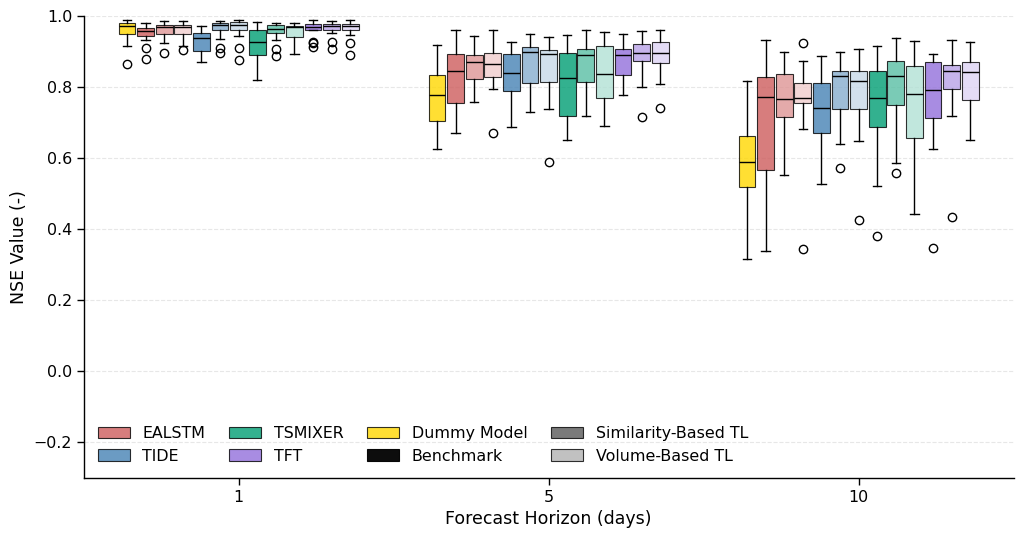

In [17]:
fig, ax = plot_horizon_performance_boxplots(
    results,
    horizons=[1, 5, 10],
    metric="nse",
    architectures=["ealstm", "tide", "tsmixer", "tft"],
    variants=["benchmark", "similar", "low_hii"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    figsize=(12, 6),
    show_median_labels=True,
    dummy_model="dummy",
    variant_mapping={
        "benchmark": "Benchmark",
        "similar": "Similarity-Based TL",
        "low_hii": "Volume-Based TL",
        "regional": "Regional Transfer Learning",
    },
)

ax.set_ylabel("NSE Value (-)")
ax.set_ylim(-0.3, 1)
ax.set_title("")
sns.despine()

path_to_save = f"{IMAGE_SAVE_FOLDER}/horizon_performance_boxplots.png"

plt.savefig(path_to_save, bbox_inches='tight', dpi=300)

plt.show()

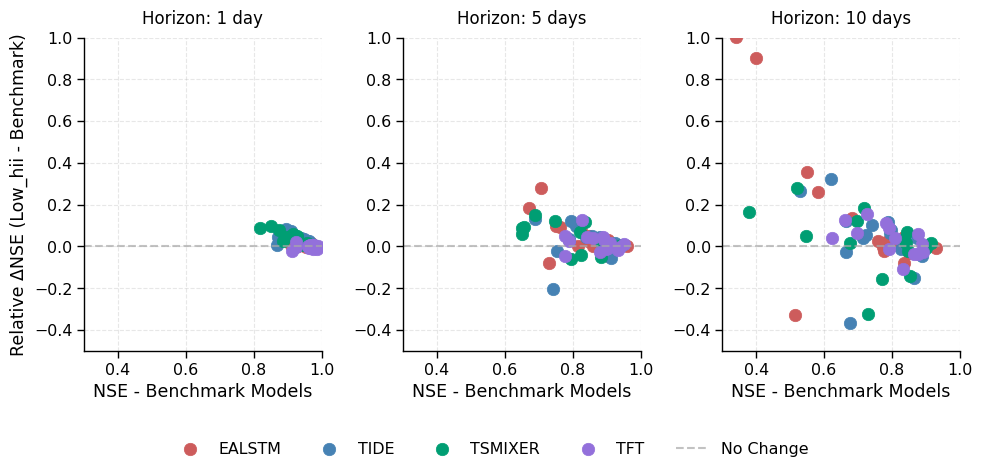

In [18]:
fig, ax = plot_basin_performance_scatter(
    results,
    benchmark_pattern="benchmark",
    challenger_pattern="low_hii",
    horizon=[1, 5, 10],
    architectures=["ealstm", "tide", "tsmixer", "tft"],
    metric="nse",
    figsize=(10, 4),
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    debug=False,
    x_limits=(0.3, 1),
    y_limits=(-0.5, 1),
    relative=True
)
sns.despine()
path_to_save = f"{IMAGE_SAVE_FOLDER}/benchmark_vs_delta.png"

plt.savefig(path_to_save, bbox_inches='tight', dpi=300)


plt.show()

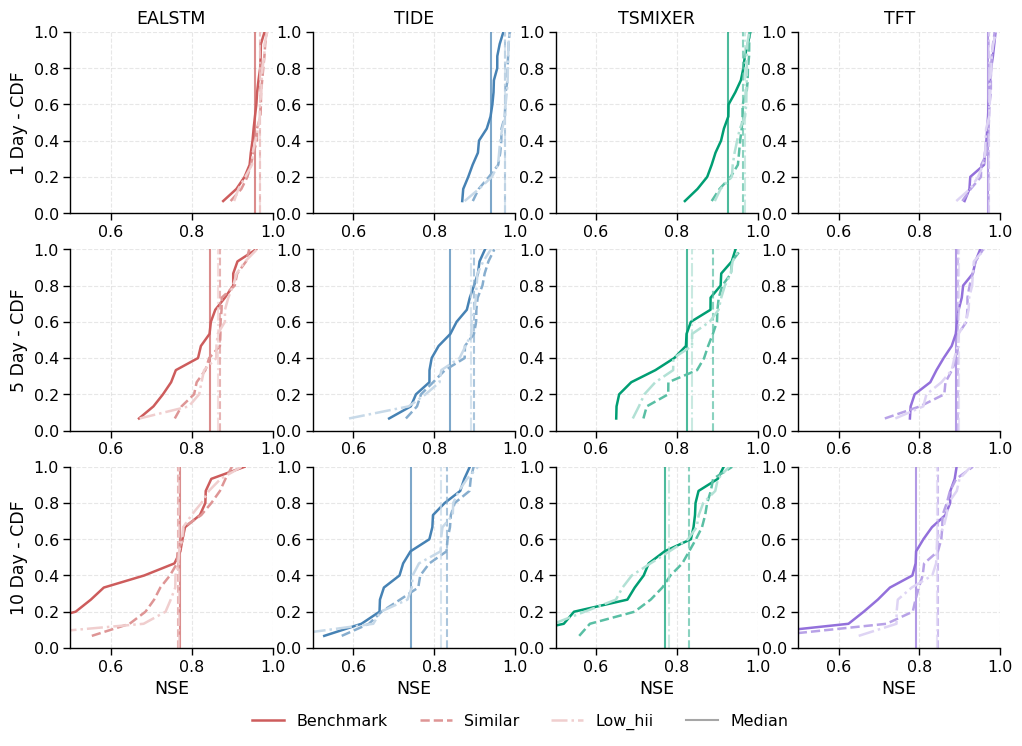

In [19]:
fig, axes = plot_model_cdf_grid(
    results,
    horizons=[1, 5, 10],
    metric="nse",
    architectures=["ealstm", "tide", "tsmixer", "tft"],
    variants=["benchmark", "similar", "low_hii"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    figsize=(12, 8),
)

sns.despine()
plt.show()

In [20]:
summary_df, latex_code = generate_performance_summary(
    results,
    metrics=["nse", "kge", "rmse", "mae"],
    higher_is_better={"nse": True, "kge": True, "rmse": False, "mae": False, "pearson_r": True, "atpe": False},
    decimal_places=2
)

In [21]:
latex_code

"\\begin{table}[htbp]\n\\centering\n\\caption{Model Performance Summary}\n\\begin{tabular}{llrrrr}\n\\toprule\n\\textbf{Architecture} & \\textbf{Variant} & \\textbf{NSE} & \\textbf{KGE} & \\textbf{RMSE} & \\textbf{MAE} \\\\\n\\midrule\n\\textbf{EALSTM} & benchmark & 0.85 ± 0.14* & 0.89 ± 0.10* & 0.42 ± 0.42 & 0.26 ± 0.24* \\\\\n & low_hii & \\textbf{0.87 ± 0.10} & 0.89 ± 0.07* & \\textbf{0.38 ± 0.32} & 0.25 ± 0.20* \\\\\n & similar & 0.86 ± 0.09* & \\textbf{0.91 ± 0.07} & 0.39 ± 0.34* & \\textbf{0.24 ± 0.23} \\\\\n\\textbf{TFT} & benchmark & 0.88 ± 0.10* & \\textbf{0.93 ± 0.07} & 0.35 ± 0.33* & 0.22 ± 0.20* \\\\\n & low_hii & \\textbf{0.90 ± 0.07} & 0.91 ± 0.06* & 0.35 ± 0.31* & \\textbf{0.22 ± 0.19} \\\\\n & similar & 0.90 ± 0.09* & 0.92 ± 0.06* & \\textbf{0.35 ± 0.30} & 0.22 ± 0.19* \\\\\n\\textbf{TIDE} & benchmark & 0.84 ± 0.09 & 0.87 ± 0.06 & 0.45 ± 0.35* & 0.29 ± 0.22 \\\\\n & low_hii & 0.88 ± 0.11* & 0.91 ± 0.06* & \\textbf{0.34 ± 0.40} & 0.23 ± 0.22* \\\\\n & similar & \\textbf{

In [22]:
summary_df

,Architecture,Variant,nse,kge,rmse,mae
0,EALSTM,benchmark,0.85 ± 0.14*,0.89 ± 0.10*,0.42 ± 0.42,0.26 ± 0.24*
1,EALSTM,low_hii,**0.87 ± 0.10**,0.89 ± 0.07*,**0.38 ± 0.32**,0.25 ± 0.20*
2,EALSTM,similar,0.86 ± 0.09*,**0.91 ± 0.07**,0.39 ± 0.34*,**0.24 ± 0.23**
3,TFT,benchmark,0.88 ± 0.10*,**0.93 ± 0.07**,0.35 ± 0.33*,0.22 ± 0.20*
4,TFT,low_hii,**0.90 ± 0.07**,0.91 ± 0.06*,0.35 ± 0.31*,**0.22 ± 0.19**
5,TFT,similar,0.90 ± 0.09*,0.92 ± 0.06*,**0.35 ± 0.30**,0.22 ± 0.19*
6,TIDE,benchmark,0.84 ± 0.09,0.87 ± 0.06,0.45 ± 0.35*,0.29 ± 0.22
7,TIDE,low_hii,0.88 ± 0.11*,0.91 ± 0.06*,**0.34 ± 0.40**,0.23 ± 0.22*
8,TIDE,similar,**0.89 ± 0.09**,**0.91 ± 0.05**,0.37 ± 0.33*,**0.22 ± 0.20**
9,TSMIXER,benchmark,0.85 ± 0.12,0.87 ± 0.08,0.45 ± 0.37,0.32 ± 0.24


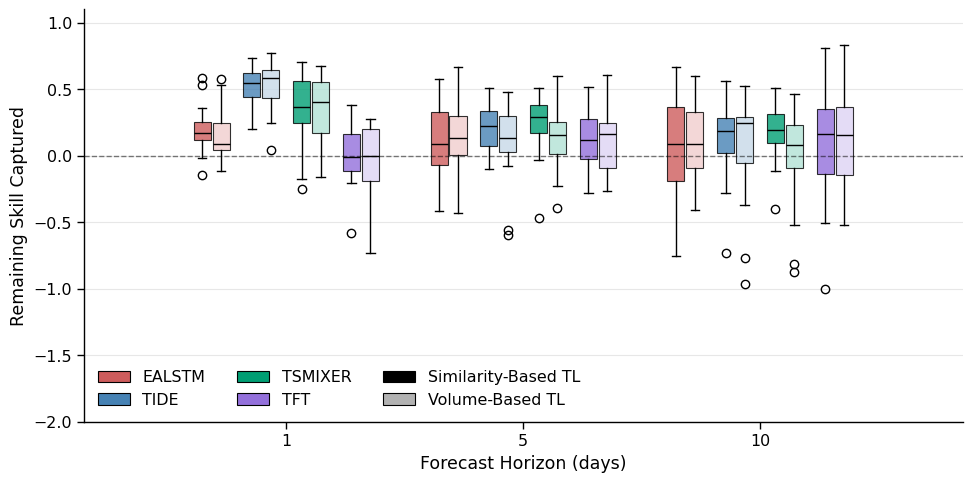

In [31]:
fig, ax = remaining_skill_captured_vs_horizon(
    results,
    benchmark_pattern="benchmark",
    challenger_patterns=["similar", "low_hii"],
    horizons=[1, 5, 10],
    architectures=["ealstm", "tide", "tsmixer", "tft"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    show_median_labels=False,
    figsize=(10, 5),
    challenger_mapping={
        "similar": "Similarity-Based TL",
        "low_hii": "Volume-Based TL",
    }
)

sns.despine()
ax.set_ylim(-2.0, 1.1)
# path_to_save = f"{IMAGE_SAVE_FOLDER}/remaining_skill_captured_vs_horizon.png"

# plt.savefig(path_to_save, bbox_inches="tight")
plt.show()

In [24]:
print_performance_summary(
    results=results,
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    variants=["benchmark", "similar", "low_hii"],
    horizons=[1, 5, 10]
)


Performance Summary for NSE:

TIDE - benchmark:
  Horizon  1: 0.939 ± 0.033 (n=15 basins)
  Horizon  5: 0.840 ± 0.069 (n=15 basins)
  Horizon 10: 0.741 ± 0.099 (n=15 basins)

TIDE - similar:
  Horizon  1: 0.974 ± 0.027 (n=15 basins)
  Horizon  5: 0.898 ± 0.068 (n=15 basins)
  Horizon 10: 0.830 ± 0.095 (n=15 basins)

TIDE - low_hii:
  Horizon  1: 0.975 ± 0.030 (n=15 basins)
  Horizon  5: 0.892 ± 0.088 (n=15 basins)
  Horizon 10: 0.816 ± 0.116 (n=15 basins)

EALSTM - benchmark:
  Horizon  1: 0.957 ± 0.026 (n=15 basins)
  Horizon  5: 0.844 ± 0.082 (n=15 basins)
  Horizon 10: 0.772 ± 0.171 (n=15 basins)

EALSTM - similar:
  Horizon  1: 0.970 ± 0.024 (n=15 basins)
  Horizon  5: 0.871 ± 0.053 (n=15 basins)
  Horizon 10: 0.765 ± 0.091 (n=15 basins)

EALSTM - low_hii:
  Horizon  1: 0.968 ± 0.023 (n=15 basins)
  Horizon  5: 0.865 ± 0.066 (n=15 basins)
  Horizon 10: 0.769 ± 0.124 (n=15 basins)

TSMIXER - benchmark:
  Horizon  1: 0.927 ± 0.046 (n=15 basins)
  Horizon  5: 0.824 ± 0.103 (n=15 basi

In [25]:
# fig, ax = plot_median_performance_across_models(
#     results=results,
#     architectures=["tide", "tsmixer", "tft"],
#     horizons=[1, 5, 10],
#     metric="MAE", 
#     approach_mapping={
#         "benchmark": "Baseline",
#         "low_hii": "With Low HII",
#         "similar": "With Global Data"
#     },
#     colors=["#8B5CF6", "#619E95"],
#     figsize=(10, 6),
#     title="Model Performance Comparison Across Forecast Horizons",
#     show_whiskers=False,
#     whisker_color="#383838",
#     annotate_values=False,
#     annotate_delta=True,
#     # delta_fontsize=13,
#     y_label="Mean Absolute Error (MAE)",
# )

# sns.despine()
# plt.tight_layout()
# ax.set_ylim(0, 0.4)
# ax.set_title("")

# # path_to_save = "/Users/cooper/Desktop/hydro-forecasting/images/wb_plots/plot_median_performance_across_models.png"

# # plt.savefig(path_to_save, dpi=300, bbox_inches='tight')
# plt.show()

In [26]:
# config_ca = CaravanifyParquetConfig(
#     attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
#     timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
#     shapefile_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CA/post_processed/shapefiles",
#     gauge_id_prefix="CA",
#     use_hydroatlas_attributes=True,
#     use_caravan_attributes=True,
#     use_other_attributes=True,
# )

# caravan_ca = CaravanifyParquet(config_ca)

# caravan_ca._load_static_attributes(country_ids)
# statics = caravan_ca.get_static_attributes()


# fig, axes = plot_performance_vs_static_attributes(
#     results,
#     static_df=statics,
#     static_attributes=["p_mean", "ele_mt_sav", "frac_snow"],
#     model_names=["tide_low_hii"],
#     horizons=[5],
#     metric="nse",
#     figsize=(11, 4),
#     attribute_labels={
#         "p_mean": "Mean Precipitation (mm/d)",
#         "ele_mt_sav": "Mean Elevation (m.a.s.l.)",
#         "frac_snow": "Precipitation Falling as Snow (%)",
#     },
# )

# sns.despine()
# # set y lim to (0, 1)
# for ax in axes.flatten():
#     ax.set_ylim(0.0, 1)
#     ax.set_title("")
# plt.show()


In [27]:
# fig, ax = plot_ensemble_rolling_forecast(
#     results=results,
#     gauge_id="CA_17453",
#     horizon=10,
#     variants=["benchmark", "similar"],
#     architectures=["tide", "ealstm", "tsmixer", "tft"],
#     figsize=(10, 5),
#     colors={"benchmark" : "#8B5CF6", "similar": "#ff2020"},
#     start_date="2022-03-01",
#     end_date="2022-10-01",
#     )

# sns.despine()
# ax.set_ylabel("Streamflow (mm/d)")
# plt.title("")
# plt.show()

In [28]:
# fig, ax = plot_rolling_forecast(
#     results,
#     model_names=["tft_finetuned"],
#     gauge_id="CA_17077",
#     horizon=5,
#     figsize=(20, 6),
#     colors={
#         "tft_benchmark": "#4682B4",
#         "tft_finetuned": "#CD5C5C",
#     },
#     observed_color="#556C89",
# )

# sns.despine()
# ax.set_xlabel("")
# ax.set_ylabel("Streamflow (mm/day)")

# plt.show()